## Caso de Uso: Pronóstico de la demanda de productos de Mayor Impacto, mediante de análisis Series Temporales.

**_Descripción_**

El presente estudio corresponde al Análisis de los datos de un negocio real de un Bar-Restaurant especializado en Hamburguesas. Los datos se encuentran comprendidos entre julio del 2023 y febrero del 2025.  La información proviene directamente del sistema contable utilizado por el propio negocio y corresponde además a uno de los locales.

Este Análisis es continuidad del estudio previo realizado en el notebook __**tfm_eda_notebook_Jorge_Arce**__.

**_Objetivo General_:**

El presente trabajo tiene como objetivo general, la predicción de las ventas  futuras por categorías más demandadas que podría tener el negocio.


**_Objetivos Específicos_:**
 - Modelar mediante análisis de Series Temporales el pronóstico de las ventas futuras de las categorías más demandadas.
 - Validar el modelo seleccionado.

 __NOTA: El análisis se realizará sobre el data set obtenido en la etapa de preprocesamiento y eda, por lo cual se prescindirá de este apartado, pasando directamente al análisis exploratorio de las series temporales asociados a las categorías de productos.__

#### **Carga Inicial:**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go 

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import STL
import pymannkendall as mk
from scipy.stats import kruskal
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet.diagnostics import cross_validation, performance_metrics
import itertools


#### **1. Recopilación de Datos**

***1.1. Carga Inicial de Datos:***

In [2]:
df_hystoric = pd.read_parquet('./data-sets/data_hitorico_ventas_mod.parquet')
df_hystoric.head(3)

,operacion,fecha,mercancia,grupo_mercancia,nombre_socio,cantidad,medida,precio_venta,importe,suma_total,dia_semana,tipo_dia,nombre_festivo,es_fin_semana,es_festivo
0,4593,2023-07-04 12:07:00,Cigarro H.Upman Con filtro,CIGARROS,Cliente2,1.0,U,190.0,190.0,190.0,Martes,Laborable,No Festivo,0,0
1,4598,2023-07-04 12:27:00,Espagueti de Jamon,PASTAS,Cliente2,2.0,U,549.0,1098.0,1098.0,Martes,Laborable,No Festivo,0,0
2,4598,2023-07-04 12:27:00,Termo Pack,INSUMOS VENTA,Cliente2,2.0,U,30.0,60.0,60.0,Martes,Laborable,No Festivo,0,0


In [3]:
df_day = pd.read_csv('./data-sets/dias_laborables_festivos_cuba.csv', encoding='utf-8')

#### **2. Limpieza y procesamiento de datos:**

**2.1. Análisis del tipo de datos de las variables.**

In [4]:
df_hystoric.dtypes

operacion                   int64
fecha              datetime64[ns]
mercancia                  object
grupo_mercancia            object
nombre_socio               object
cantidad                  float64
medida                     object
precio_venta              float64
importe                   float64
suma_total                float64
dia_semana                 object
tipo_dia                   object
nombre_festivo             object
es_fin_semana               int32
es_festivo                  int32
dtype: object

Resultados:
- Al ser un fichero en formato parquet, se cargan las variables con su tipo de datos original.


**2.2. Análisis de la variable grupo_mercancia (categoria).**

In [5]:
df_hystoric.describe(include="all")

,operacion,fecha,mercancia,grupo_mercancia,nombre_socio,cantidad,medida,precio_venta,importe,suma_total,dia_semana,tipo_dia,nombre_festivo,es_fin_semana,es_festivo
count,1.915650e+05,191565,191565,191565,191565,191565.000000,191565,191565.000000,191565.000000,191565.000000,191565,191565,191565,191565.00000,191565.000000
unique,NaN,NaN,338,23,11,NaN,2,NaN,NaN,NaN,7,3,12,NaN,NaN
top,NaN,NaN,Croquetas de Jamon,BATIDOS,!Cliente,NaN,U,NaN,NaN,NaN,Domingo,Laborable,No Festivo,NaN,NaN
freq,NaN,NaN,10527,27193,142004,NaN,180070,NaN,NaN,NaN,35790,119443,186121,NaN,NaN
mean,4.137932e+05,2024-05-28 22:38:09.707932160,NaN,NaN,NaN,1.640354,NaN,436.986847,695.136266,695.150606,NaN,NaN,NaN,0.34807,0.028419
min,4.593000e+03,2023-07-04 12:07:00,NaN,NaN,NaN,0.500000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.00000,0.000000
25%,2.834700e+04,2024-01-01 21:25:00,NaN,NaN,NaN,1.000000,NaN,190.000000,250.000000,250.000000,NaN,NaN,NaN,0.00000,0.000000
50%,4.842400e+04,2024-06-10 18:53:00,NaN,NaN,NaN,1.000000,NaN,400.000000,510.000000,510.000000,NaN,NaN,NaN,0.00000,0.000000
75%,1.066613e+06,2024-10-29 21:34:00,NaN,NaN,NaN,2.000000,NaN,570.000000,887.400000,889.000000,NaN,NaN,NaN,1.00000,0.000000
max,1.079486e+06,2025-02-28 23:51:00,NaN,NaN,NaN,334.000000,NaN,18150.000000,80000.000000,80000.000000,NaN,NaN,NaN,1.00000,1.000000


Resultados:
- El análisis preliminar coincide corresponden a los resultados obtenidos en el EDA.
- Se puede observar que el producto de mayor frequencia es Croqueta de jamón, pero no es el da mayor demanda. Pudiendo indicar que se compre muy seguido pero en cantidades inferiores a otros productos.

#### **3. Análisis Exploratorio de la característica **grupo_mercancia****

**3.1. Distribución de las categorías según la demanda**

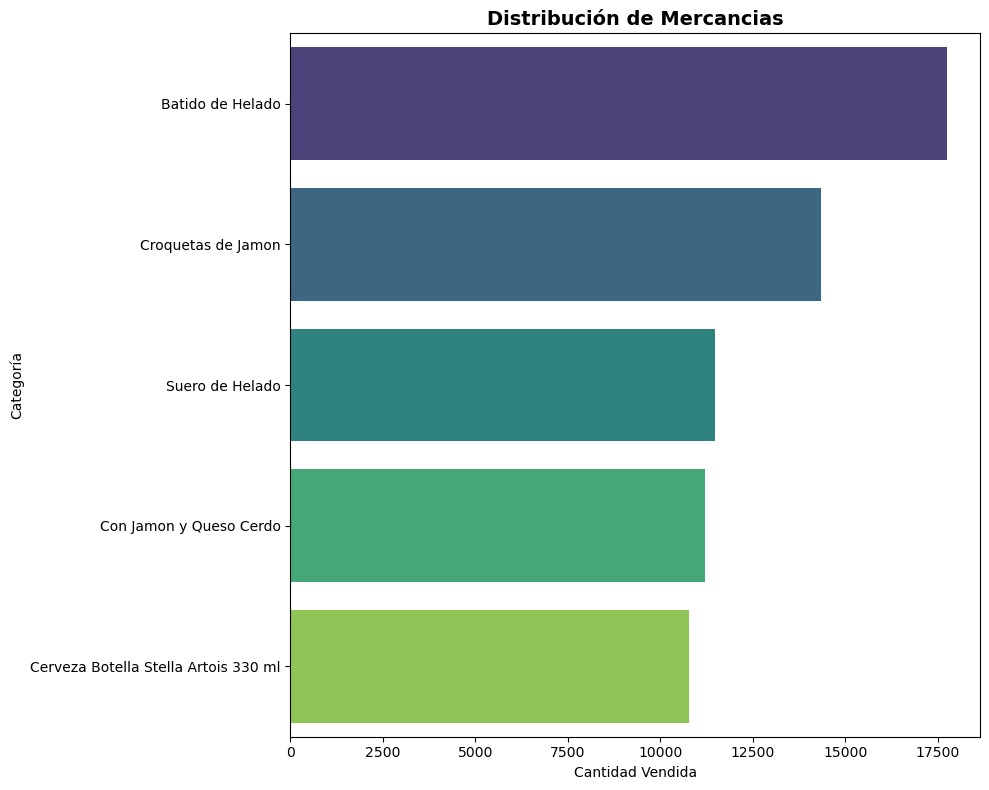

In [6]:
df_top_category = df_hystoric.groupby('mercancia', as_index=False).agg({'cantidad':'sum'}).sort_values(by='cantidad', ascending=False).head(5)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_top_category, x='cantidad', y='mercancia', palette='viridis')
plt.title('Distribución de Mercancias', fontsize=14, fontweight='bold')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Categoría')
plt.tight_layout()
plt.show()

Resultados:
- Como es observable en el Top 5 de las categorías más vendidas se encuetnra Insumos que no representa valor de análisis para pronósticar.
- Por la importancia que representan se analizarán las tres primeras categorías, a modo de demostración. Quedando sujeto a la decisión del cliente cuales serían las categorías de interés para predecir su demanda.

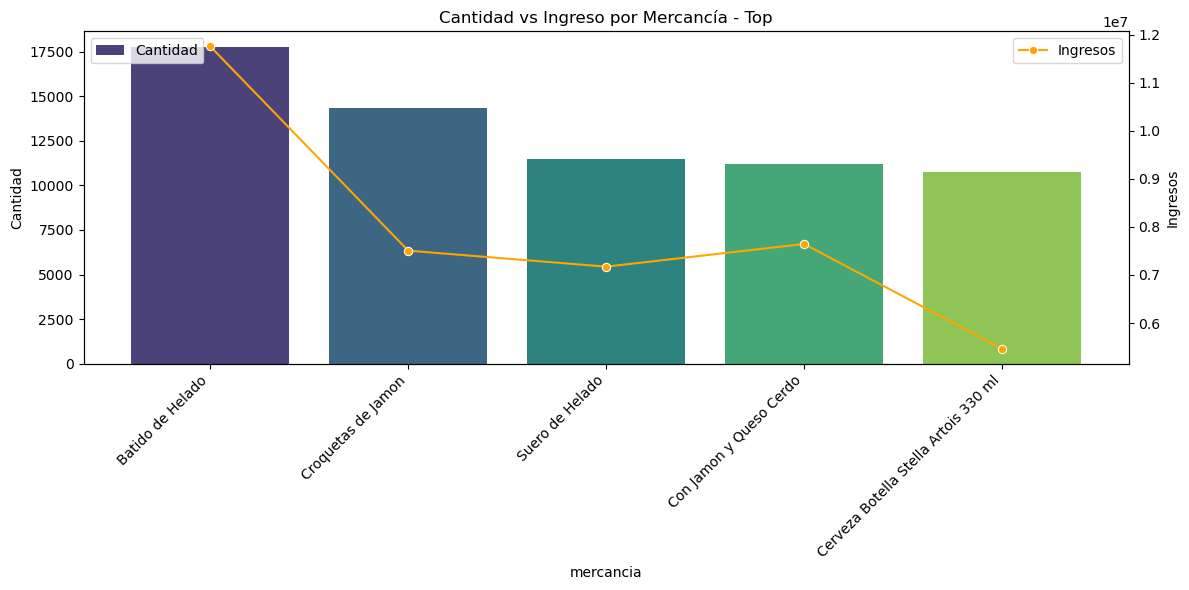

In [7]:
df_agg = df_hystoric.groupby('mercancia', as_index=False).agg({
    'cantidad': 'sum',
    'suma_total': 'sum'
})

top = df_agg.sort_values(by='cantidad', ascending=False).head(5)

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(data=top, x='mercancia', y='cantidad', ax=ax1, palette='viridis', label='Cantidad')
ax1.set_ylabel('Cantidad')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

ax2 = ax1.twinx()
sns.lineplot(data=top, x='mercancia', y='suma_total', ax=ax2, color='orange', marker='o', label='Ingresos')
ax2.set_ylabel('Ingresos')

plt.title('Cantidad vs Ingreso por Mercancía - Top')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Resultados:
- El resultado corrobora la afirmación anterior, que las "Croquetas de Jamón" son las que mayor frequencia piden los usuarios por ticket, pero no la de mayor cantidad por pedidos. 

#### **4. Análisis Exploratorio de la Serie de Tiempo.**

**4.1. Analizando el producto con mayor impacto. Batido de Helado**

4.1.1. Seleccionando Batido de Helado

In [8]:
df_top_producto = df_hystoric[df_hystoric["mercancia"]=="Batido de Helado"]
df_top_producto.head()

,operacion,fecha,mercancia,grupo_mercancia,nombre_socio,cantidad,medida,precio_venta,importe,suma_total,dia_semana,tipo_dia,nombre_festivo,es_fin_semana,es_festivo
76,4671,2023-07-04 18:40:00,Batido de Helado,BATIDOS,Cliente2,2.0,U,285.0,570.0,570.0,Martes,Laborable,No Festivo,0,0
453,4874,2023-07-06 11:47:00,Batido de Helado,BATIDOS,Cliente2,1.0,U,285.0,285.0,285.0,Jueves,Laborable,No Festivo,0,0
483,4889,2023-07-06 13:11:00,Batido de Helado,BATIDOS,Cliente2,1.0,U,285.0,285.0,285.0,Jueves,Laborable,No Festivo,0,0
502,4897,2023-07-06 13:46:00,Batido de Helado,BATIDOS,Cliente2,1.0,U,285.0,285.0,285.0,Jueves,Laborable,No Festivo,0,0
515,4902,2023-07-06 14:30:00,Batido de Helado,BATIDOS,Cliente2,1.0,U,285.0,285.0,285.0,Jueves,Laborable,No Festivo,0,0


4.1.2. Representando la Serie Temporal con variables exógenas.

In [9]:
df_top_producto = df_top_producto.groupby(df_top_producto["fecha"].dt.floor('D'), as_index=True).agg({
    'cantidad': 'sum',
    'es_festivo': 'max',
    'es_fin_semana': 'max',      
})
df_top_producto

,cantidad,es_festivo,es_fin_semana
fecha,,,
2023-07-04,2.0,0,0
2023-07-06,17.0,0,0
2023-07-07,13.0,0,0
2023-07-09,2.0,0,1
2023-07-10,13.0,0,0
...,...,...,...
2025-02-24,14.0,0,0
2025-02-25,33.0,0,0
2025-02-26,25.0,0,0


NOTA: Se realiza análisis diario ya que se intentó realiar semanal pero da muy pocos resultados aproximadamente 70 vaores a partir del pequeño tamaño del dataset. Además que aprovecha las ventajas de algunos modelos que permiten ajustar estacionalidad

In [10]:
# Suavisando con Media Móvil en un período semanal. 
nivel_suavizado = df_top_producto['cantidad'].rolling(window=7, center=True).mean()
media_general = df_top_producto['cantidad'].mean()

fig = px.line(df_top_producto, x=df_top_producto.index, y='cantidad', title='Ventas Diarias de Batidos de Helado con Suavizado Semanal',  labels={'cantidad': 'Ventas Diarias'})
fig.add_scatter(x=df_top_producto.index, y=nivel_suavizado, mode='lines', name='Suavizado (7 días)', line=dict(color='red'))
fig.add_trace(go.Scatter(x=[df_top_producto.index.min(), df_top_producto.index.max()], y=[media_general, media_general], mode='lines', name=f"Media general ({media_general:.2f})", line=dict(color='green', dash='dash')))
fig.show()

Resultados:
- La línea azul muestra las ventas diarias originales, evidenciando una gran variabilidad día a día, característica común en productos de consumo inmediato. Sin embargo, se aprecia una cierta estabilidad en la magnitud de estas fluctuaciones hacia el final del periodo analizado, lo cual puede indicar una mejor gestión operativa o mayor madurez del negocio.
- El análisis revela un periodo de ventas mínimas o nulas entre el 8 y el 25 de enero de 2024. Según información del negocio, esto coincide con el cierre temporal del local por reparaciones. Este tipo de eventos debe ser registrado y considerado en el modelado futuro para evitar interpretaciones erróneas o distorsión en los modelos predictivos.
- Tras el cierre de enero 2024, se observa una recuperación progresiva de las ventas, estabilizándose nuevamente alrededor de la media general, con algunos picos destacados hacia finales de 2024 e inicios de 2025. Esto muestra la resiliencia del negocio y la efectividad en la recuperación de clientes.
- Se valida la existencia de estacionalidad semanal (ciclos regulares dentro de cada mes), muy útil para planificar inventario y promociones.Además, se observa un ligero crecimiento en los picos de ventas hacia el final de la serie, lo cual puede ser señal de campañas exitosas, mejores condiciones externas o posicionamiento de marca.


4.1.3. Descomposición estacional de la serie. STL

In [11]:
def stl_descomposition(df_category, name):
    descomp_stl = STL(df_category['cantidad'], period=7).fit()

    fig_stl = descomp_stl.plot()
    fig_stl.set_size_inches(15, 10)
    plt.suptitle(f"Descomposición de la serie {name} - Cantidad", fontsize=16)
    plt.show()
    
    return descomp_stl

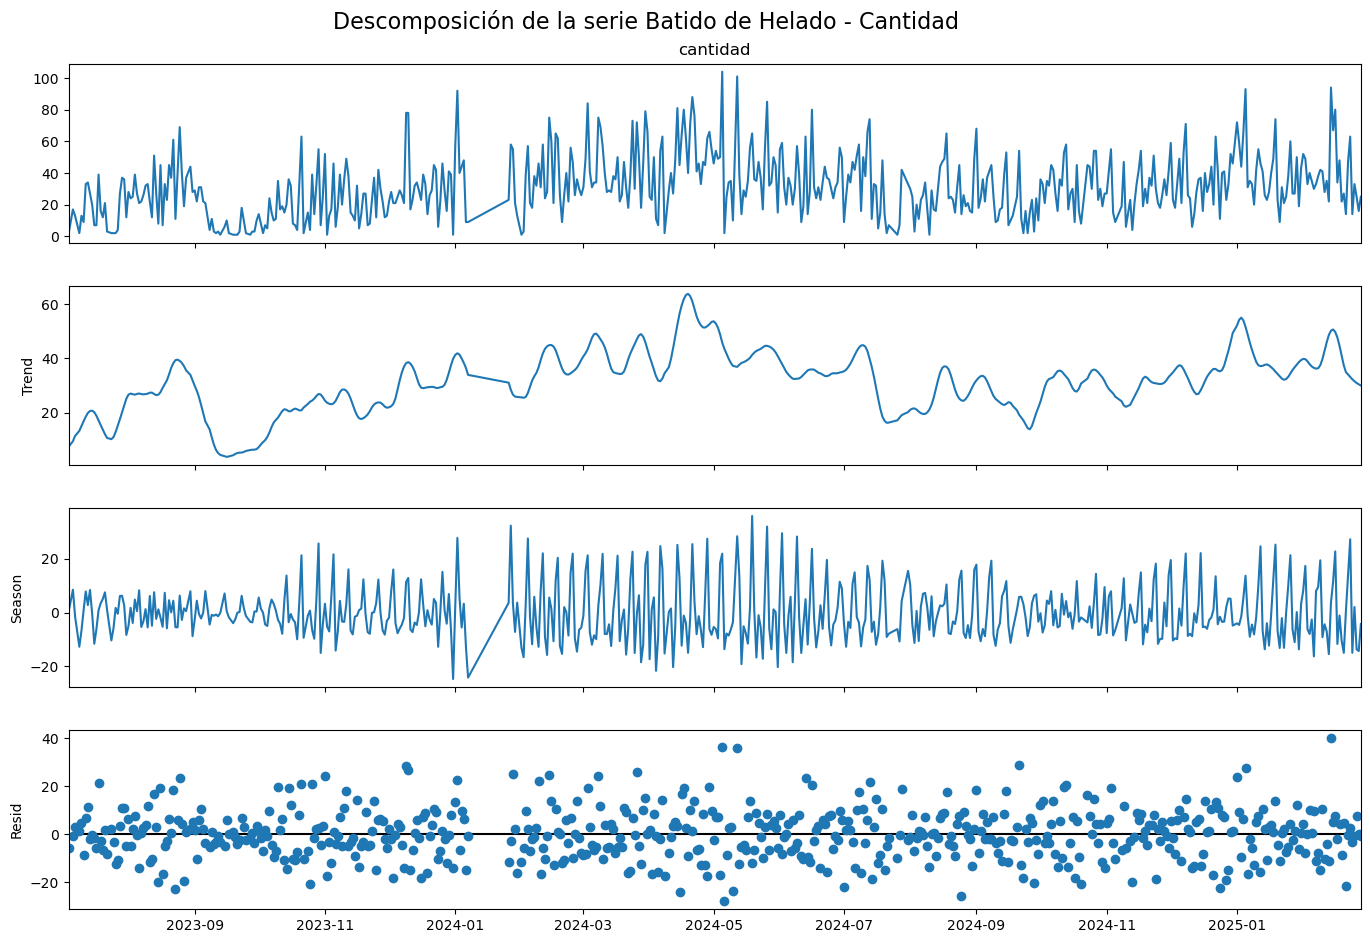

In [12]:
stl_descomp = stl_descomposition(df_top_producto, "Batido de Helado")

4.1.4. Validación Estadística de la Descomposición STL

4.1.4.1 Análisis del Componente Tendencia. Prueba Mann-Kendall (Tendencia constante).

In [13]:
def trend_component(stl_desc):
    resultado_trend = mk.original_test(stl_desc.trend.dropna())
    print(resultado_trend)

In [14]:
trend_component(stl_descomp)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=9.108928906659239, Tau=0.25650328155902397, s=40724.0, var_s=19986875.333333332, slope=0.025362522801226237, intercept=25.44747286098203)


1.1.11. Análisis del Componente Estacionalidad. Prueba Kruskal-Wallis (Estacionalidad significativa por grupos)**

In [15]:
def seasonal_component(df_category, stl_desc):
    df_kruskal = df_category.copy()
    df_kruskal['dia_semana'] = df_category.index.dayofweek 

    grupos = [stl_desc.seasonal[df_kruskal['dia_semana'] == d].values for d in range(7)]

    stat, p_kw = kruskal(*grupos)
    print(f"Kruskal-Wallis p-value: {p_kw}")

In [17]:
seasonal_component(df_top_producto, stl_descomp)

Kruskal-Wallis p-value: 1.646990372109658e-39


**4.3.3. Análisis del Componente Residuos. Ljung-Box (Autocorrelación de residuos)**

_=> Hipótesis Nula(Ho): No existe autocorrelación entre los residuos. (Los residuos son ruido blanco)_

In [18]:
def resid_component(stl_desc):
    # Se utilizan retardos de una semana y multiplos de 7.
    ljungbox = acorr_ljungbox(stl_desc.resid.dropna(), lags=[7, 14, 21, 28], return_df=True)
    print(ljungbox)

In [19]:
resid_component(stl_descomp)

       lb_stat     lb_pvalue
7   197.681668  3.554245e-39
14  230.158021  3.576885e-41
21  241.057209  2.549404e-39
28  248.351015  3.523940e-37


**4.3. Análisis de Autocorrelaciones**

In [21]:
def autocorr_analisys(df_category):
    plot_acf(df_category['cantidad'].dropna(), lags=28)
    plt.title('Autocorrelación de la serie')
    plt.show()

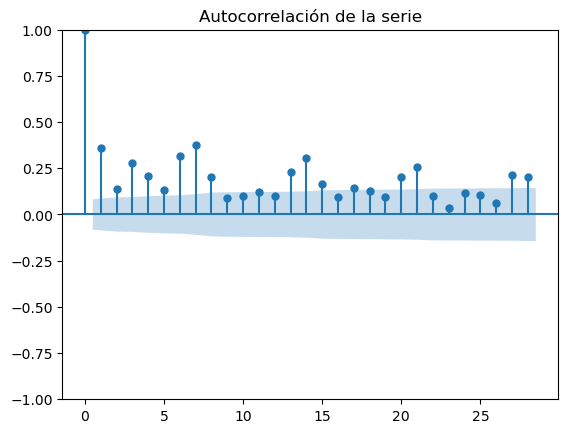

In [22]:
autocorr_analisys(df_top_producto)

**4.4. Prueba de Estacionariedad. Prueba de Dickey-Fuller Aumentada (Raíz unitaria)**

_=> Hipótesis Nula(Ho): No es estacionaria. (Tiene una raíz unitaria)_

In [23]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(df_category):
    resultado_adf = adfuller(df_category['cantidad'].dropna())  # importante eliminar NaNs

    # Mostrar resultados
    print('ADF Statistic:', resultado_adf[0])
    print('p-value:', resultado_adf[1])
    print('Valores críticos:')
    for clave, valor in resultado_adf[4].items():
        print(f'   {clave}: {valor}')

In [24]:
adfuller_test(df_top_producto)

ADF Statistic: -3.4132460005528165
p-value: 0.010515519719797459
Valores críticos:
   1%: -3.442295604706236
   5%: -2.866809328264463
   10%: -2.569576376859504


Resultados Generales:
- La descomposición de la serie temporal evidenció una tendencia general creciente en las ventas, confirmada formalmente mediante la prueba de Mann-Kendall, que arrojó un resultado de tendencia creciente estadísticamente significativa (p=0.0).
- Existe una estacionalidad semanal muy marcada, observada tanto en el suavizado de la serie como en los análisis de autocorrelación y en la descomposición estacional. Las ventas presentan ciclos repetitivos que se corresponden con los días de la semana.
- Se identificó un periodo de ventas nulas (enero 2024) coincidente con el cierre temporal del local por reparaciones, lo que destaca la importancia de considerar eventos externos y estructurales en el análisis y modelado.
- En comparación interanual, se detectó una recuperación y estabilización de las ventas tras dicho evento, con picos de ventas incluso superiores hacia finales del periodo analizado.
- La prueba de Kruskal-Wallis confirmó la existencia de diferencias estadísticamente significativas entre grupos de datos (por ejemplo, días de la semana o temporadas), con un p-value extremadamente bajo. 
- Los resultados de la prueba de Ljung-Box y el gráfico de autocorrelación muestran autocorrelación significativa en los residuos y en la propia serie, especialmente en rezagos semanales, lo que refuerza la presencia de memoria y patrones persistentes en el comportamiento de las ventas.
- Este resultado sugiere la necesidad de emplear modelos que capturen dependencias temporales y estructuras estacionales (como SARIMA o Prophet).
- La prueba de Dickey-Fuller aumentada (ADF) indicó que la serie es estacionaria al 5% de significancia. Esto indica que aunque los resultados anteriores indiquen aún tendencias y estacionalidades, no presenta una raíz unitaria, por lo que puede considerarse estacionaria.
- El negocio de batidos de helado presenta una dinámica de ventas creciente, alta estacionalidad semanal y diferencias significativas entre periodos, lo que permite diseñar estrategias específicas para cada ciclo temporal.
- Los modelos de predicción utilizado deben capturar tanto la tendencia como la estacionalidad, y considerar la autocorrelación observada en la serie.
- Por tanto, se concluye que la serie no es completamente estacionaria, pero no es necesario aplicar diferenciación, dado que pueden utilizarce modelos de predicción qué manejen explícitamente componentes de tendencia y estacionalidad.
- Esta decisión evita una transformación innecesaria de los datos y permitiría preservar la interpretabilidad del comportamiento real del negocio.


#### **5. Construcción del Modelo predictivo.**

In [92]:
# Creando train y test.
df_train = df_top_producto[df_top_producto.index < '2024-11-30']
df_test = df_top_producto[df_top_producto.index >= '2024-12-01']


# Obtención de las variables exógenas
exog_train = df_train[['es_festivo', 'es_fin_semana']]
exog_test = df_test[['es_festivo', 'es_fin_semana']]


**5.1.1. Modelo STL+SARIMAX**

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Descomposición STL sobre el set de entrenamiento. 
# A partir de los resultados del análisis que demuestran una etacionadlidad semanal se selecciona un período de 7 días.
stl = STL(df_train['cantidad'], period=7)
stl_result = stl.fit()

# Extraer componentes de la Serie
trend = stl_result.trend
seasonal = stl_result.seasonal
resid = stl_result.resid

# Alinear residuos y variables exógenas
resid_model = resid.dropna()
exog_model = exog_train.loc[resid_model.index]


# Crea el modelo SARIMAX sobre los residuos.
model_stl_smx = SARIMAX(resid_model, exog=exog_model, order=(3, 0, 3), enforce_stationarity=False)
model_stl_sarimax = model_stl_smx.fit(disp=False)

n_test = len(exog_test)
forecast_resid = model_stl_sarimax.forecast(steps=n_test, exog=exog_test)

trend_forecast = np.repeat(trend.iloc[-1], n_test)
# Estacionalidad: repite el patrón semanal sobre el periodo de test
seasonal_pattern = seasonal[-7:].values  # último patrón semanal
seasonal_test = np.tile(seasonal_pattern, int(np.ceil(n_test / 7)))[:n_test]

# Reconstruye la serie predicha
forecast_stl_sarimax = trend_forecast + seasonal_test + forecast_resid.values
forecast_stl_sarimax = pd.Series(forecast_stl_sarimax, index=df_test.index, name='predicho')


actual = df_test['cantidad']
rmse_stl_smx = np.sqrt(mean_squared_error(actual, forecast_stl_sarimax))
mae_stl_smx = mean_absolute_error(actual, forecast_stl_sarimax)
mape_stl_smx = np.mean(np.abs((actual - forecast_stl_sarimax) / actual)) * 100
r2_stl_sarimax = r2_score(actual, forecast_stl_sarimax)
print(f"STL+SARIMAX: RMSE: {rmse_stl_smx:.2f}, MAE: {mae_stl_smx:.2f}, MAPE: {mape_stl_smx}, R2: {r2_stl_sarimax: .4f}, RMSE Relative: { rmse_stl_smx/np.mean(forecast_stl_sarimax) }")


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



STL+SARIMAX: RMSE: 21.83, MAE: 16.66, MAPE: 47.80793399737889, R2: -0.4908, RMSE Relative: 0.7559181727897951


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



**5.1.2. SARIMAX**

In [94]:
model_smx = SARIMAX(
    df_train['cantidad'],
    exog=exog_train,
    order=(3,0,3),
    seasonal_order=(1,0,1,7),
    enforce_stationarity=False
)
fit_smx = model_smx.fit(disp=False)

# Predicción para el periodo de test
forecast_smx = fit_smx.forecast(steps=len(df_test), exog=exog_test)

# Alinear las predicciones al índice de fechas del test
forecast_smx = pd.Series(forecast_smx.values, index=df_test.index, name='predicho')

actual_smx = df_test['cantidad']

rmse_smx = np.sqrt(mean_squared_error(actual_smx, forecast_smx))
mae_smx = mean_absolute_error(actual_smx, forecast_smx)
mape_smx = np.mean(np.abs((actual_smx - forecast_smx) / actual_smx)) * 100
r2_sarimax = r2_score(actual_smx, forecast_smx)
print(f"SARIMAX Directo: RMSE: {rmse_smx:.2f}, MAE: {mae_smx:.2f}, MAPE: {mape_smx:.2f}, R2:{r2_sarimax:.4f}, RMSE Relative: { rmse_smx/np.mean(forecast_smx) }")


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMAX Directo: RMSE: 15.49, MAE: 11.74, MAPE: 35.38, R2:0.2487, RMSE Relative: 0.46427484646215383


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



**5.1.3. PROPHET**

In [95]:
from prophet import Prophet

# Se ajusta el train/set debido a que requiere que las columnas sean [ds,y]
train_prophet = df_train.reset_index().rename(columns={'fecha':'ds', 'cantidad':'y'})
test_prophet = df_test.reset_index().rename(columns={'fecha':'ds', 'cantidad':'y'})

# Crear modelo con estacionalidad diaria
model_prophet = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False)

# Agregar variables exógenas como regresores
model_prophet.add_regressor('es_festivo')
model_prophet.add_regressor('es_fin_semana')

model_prophet.fit(train_prophet)

future = test_prophet[['ds', 'es_festivo', 'es_fin_semana']]
forecast = model_prophet.predict(future)

actual_prophet = df_test['cantidad'].values
forecast_prophet = forecast['yhat'].values

rmse_prophet = np.sqrt(mean_squared_error(actual_prophet, forecast_prophet))
mae_prophet = mean_absolute_error(actual_prophet, forecast_prophet)
mape_prophet = np.mean(np.abs((actual_prophet - forecast_prophet) / actual_prophet)) * 100
r2_prophet = r2_score(actual_prophet, forecast_prophet)
print(f"PROPHET: RMSE: {rmse_prophet:.2f}, MAE: {mae_prophet:.2f}, MAPE: {mape_prophet:.2f}, R2: {r2_prophet:.4f}, RMSE Relative: { rmse_prophet/np.mean(forecast_prophet) }")


17:22:13 - cmdstanpy - INFO - Chain [1] start processing
17:22:13 - cmdstanpy - INFO - Chain [1] done processing


PROPHET: RMSE: 21.42, MAE: 16.71, MAPE: 41.90, R2: -0.4352, RMSE Relative: 0.9555200489934589


**5.1.4. AutoARIMA**

In [31]:
import pmdarima as pm

y_train = df_train['cantidad']
y_test  = df_test['cantidad']

model_autoarima = pm.auto_arima(
    y=y_train,
    exogenous=exog_train,
    start_p=1, start_q=1, max_p=3, max_q=3,
    seasonal=True,
    m=7,  # Periodo de estacionalidad semanal
    start_P=0, start_Q=0, max_P=2, max_Q=2,
    d=None, D=None,  # Deja que autoarima determine si diferencia o no
    trace=True,  
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

forecast_autoarima = model_autoarima.predict(n_periods=len(y_test), exogenous=exog_test)

# Permite asegurar que no existan nulos en test
mask = ~np.isnan(y_test.values)
rmse_autoarima = np.sqrt(mean_squared_error(y_test.values[mask], forecast_autoarima[mask]))
mae_autoarima = mean_absolute_error(y_test.values[mask], forecast_autoarima[mask])
mape_autoarima = np.mean(np.abs((y_test.values[mask] - forecast_autoarima[mask]) / y_test.values[mask])) * 100
r2_autoarima = r2_score(y_test.values[mask], forecast_autoarima[mask])
rmse_rel_autoarima = rmse_autoarima / np.mean(forecast_autoarima[mask])

print(f"AUTOARIMA: RMSE: {rmse_autoarima:.2f}, MAE: {mae_autoarima:.2f}, MAPE: {mape_autoarima:.2f}, R2: {r2_autoarima:.4f}, RMSE Relative: {rmse_rel_autoarima:.2f}")


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=4052.512, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4265.955, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4188.555, Time=1.04 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4045.478, Time=2.43 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4263.958, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=4062.649, Time=0.61 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=4034.152, Time=2.23 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=4041.032, Time=1.39 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=4036.063, Time=4.97 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=4036.044, Time=4.03 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=4041.863, Time=3.37 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=4037.483, Time=5.07 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=4038.151, Time=8.62 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=4242.459, Time=1.28 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Comparación:
- STL+SARIMAX:El RMSE y MAE son altos, el MAPE es el peor de todos (casi 48%), y el R2 es negativo, indicando que el modelo predice peor que la media. No se recomienda usar este modelo en tu contexto.
- SARIMAX: Es el modelo con mejor desempeño en todos los indicadores. Tiene los errores absolutos y relativos más bajos y el único R2 positivo, lo que significa que sí explica parte de la varianza de las ventas. El MAPE es el menor (38%), mostrando mejor capacidad de predicción.
- PROPHET: El desempeño es similar a STL+SARIMAX, con errores altos y R2 negativo. Prophet no logra capturar bien la dinámica de tu serie y predice peor que la media.
- AUTOARIMA: Mejor que STL+SARIMAX y Prophet, pero inferior al SARIMAX Directo. El error sigue siendo alto y el R2 negativo, lo que lo descarta como mejor opción.



Resultados:
- El mejor modelo es el SARIMAX con los parámetros identificados identificado.
- Este modelo aprovecha tanto la dinámica temporal (tendencia, estacionalidad) como la información exógena disponible, lo que se refleja en sus métricas.
- Es el único modelo que mejora la predicción respecto a la media histórica, y su MAPE (38%) es razonable para series con alta volatilidad.
- El resto de modelos pueden quedar como referencia o para contraste, pero no se recomienda su uso operativo en tu contexto actual.

**5.2. Ajuste de Hiperparámetros y Afinamiento del modelo.**

In [129]:
# Rango de hiperparámetros a probar
p = d = q = range(1, 2)      # 0, 1, 2 para ARIMA
P = D = Q = range(0, 1)      # 0, 1 para estacionalidad
s = [7]                      # Estacionalidad semanal
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

metrics = []

def temporal_cross_val(df_train, exog_train, order, seasonal_order, n_splits=5):
    window_size = int(len(df_train) / (n_splits + 1))

    for i in range(n_splits):
        end_train = (i+1) * window_size
        train_slice = df_train.iloc[:end_train]
        val_slice = df_train.iloc[end_train:end_train+window_size]
        exog_train_slice = exog_train.iloc[:end_train]
        exog_val_slice = exog_train.iloc[end_train:end_train+window_size]
        if len(val_slice) == 0:
            break
        try:
            model = SARIMAX(
                train_slice['cantidad'],
                exog=exog_train_slice,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False
            )
            fit = model.fit(disp=False)
            pred = fit.forecast(steps=len(val_slice), exog=exog_val_slice)
            rmse = np.sqrt(mean_squared_error(val_slice['cantidad'], pred))
            mae = mean_absolute_error(val_slice['cantidad'], pred)
            mape = np.mean(np.abs((val_slice['cantidad'] - pred) / val_slice['cantidad'])) * 100
            metrics.append({'fold': int(i+1),'rmse': rmse, 'mae': mae, 'mape': mape})
        except Exception as e:
            # Puede fallar por mala convergencia en algún fold
            return {'rmse': np.nan, 'mae': np.nan, 'mape': np.nan}
    return pd.DataFrame(metrics).mean().to_dict()


results = []

for comb in param_combinations:
    order = (comb[0], comb[1], comb[2])
    seasonal_order = (comb[3], comb[4], comb[5], comb[6])
    metric = temporal_cross_val(df_train, exog_train, order, seasonal_order, n_splits=5) 
    results.append({
        'order': order,
        'seasonal_order': seasonal_order,
        'rmse_cv': metric['rmse'],
        'mae_cv': metric['mae'],
        'mape_cv': metric['mape']
    })
    # print(f"Evaluado: order={order}, seasonal_order={seasonal_order}, RMSE_cv={metric['rmse']:.2f}, MAE_cv={metric['mae']:.2f}, MAPE_cv={metric['mape']:.2f}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('rmse_cv')
print("\nMejores combinaciones (según cross-validation):")
print(results_df.head(5))


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov


Mejores combinaciones (según cross-validation):
       order seasonal_order    rmse_cv     mae_cv  mape_cv
0  (1, 1, 1)   (0, 0, 0, 7)  19.342561  14.827339      NaN


In [136]:
print("Ajuste Vs Entrenamiento directo")
print(f"Ajuste RMSE: {results_df['rmse_cv'].values[0]} -- Directo RMSE: {rmse_smx:.2f}")
print(f"Ajuste : {results_df['mae_cv'].values[0]} -- Directo RMSE: {mae_smx:.2f}")
print(f"Ajuste : {results_df['mape_cv'].values[0]} -- Directo RMSE: {mape_smx:.2f}")

Ajuste Vs Entrenamiento directo
Ajuste RMSE: 19.342561453736888 -- Directo RMSE: 15.49
Ajuste : 14.82733882817412 -- Directo RMSE: 11.74
Ajuste : nan -- Directo RMSE: 35.38


Las métricas muestran un mejor resultado en el modelo sin ajuste, lo que puede indicar que se usó una buena combinación y que el Ajuste de Hiperparámetros puiiera llevar otros parámetros diferentes.

Por lo que se utilizará las métricas obtenidas en el modelo directo

NOTA: Se intentó utilizar una mayor cantidad de hiperparámetros, pero el modelo con el computo que se cuenta duró horas, y de forma demostrativa se trabajará con los resultados que se cuentan. 

In [123]:
model_final = SARIMAX(
    df_train['cantidad'],
    exog=exog_train,
    order=(3,0,3),
    seasonal_order=(1,0,1,7),
    enforce_stationarity=False
)
fit_final = model_final.fit(disp=False)

# predicción sobre train (in-sample)
fitted_train = fit_final.fittedvalues
fitted_train.index = df_train.index

# predicción sobre test (out-of-sample)
forecast_test = fit_final.get_forecast(steps=len(df_test), exog=exog_test)
forecast_mean = forecast_test.predicted_mean
forecast_mean.index = df_test.index

# bandas de confianza
conf_int = forecast_test.conf_int(alpha=0.05)
conf_int.index = df_test.index

y_true = df_test['cantidad']
y_pred = forecast_mean
rmse_test = np.sqrt(mean_squared_error(y_true, y_pred))
mae_test = mean_absolute_error(y_true, y_pred)
mape_test = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_test = r2_score(y_true, y_pred)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [134]:
print("Evaluación final en train Vs test")
print(f"Train RMSE: {results_df['rmse_cv'].values[0]} -- Test RMSE: {rmse_test:.2f}")
print(f"Train : {results_df['mae_cv'].values[0]} -- Test RMSE: {mae_test:.2f}")
print(f"Train : {results_df['mape_cv'].values[0]} -- Test RMSE: {mape_test:.2f}")

Evaluación final en train Vs test
Train RMSE: 19.342561453736888 -- Test RMSE: 15.49
Train : 14.82733882817412 -- Test RMSE: 11.74
Train : nan -- Test RMSE: 35.38


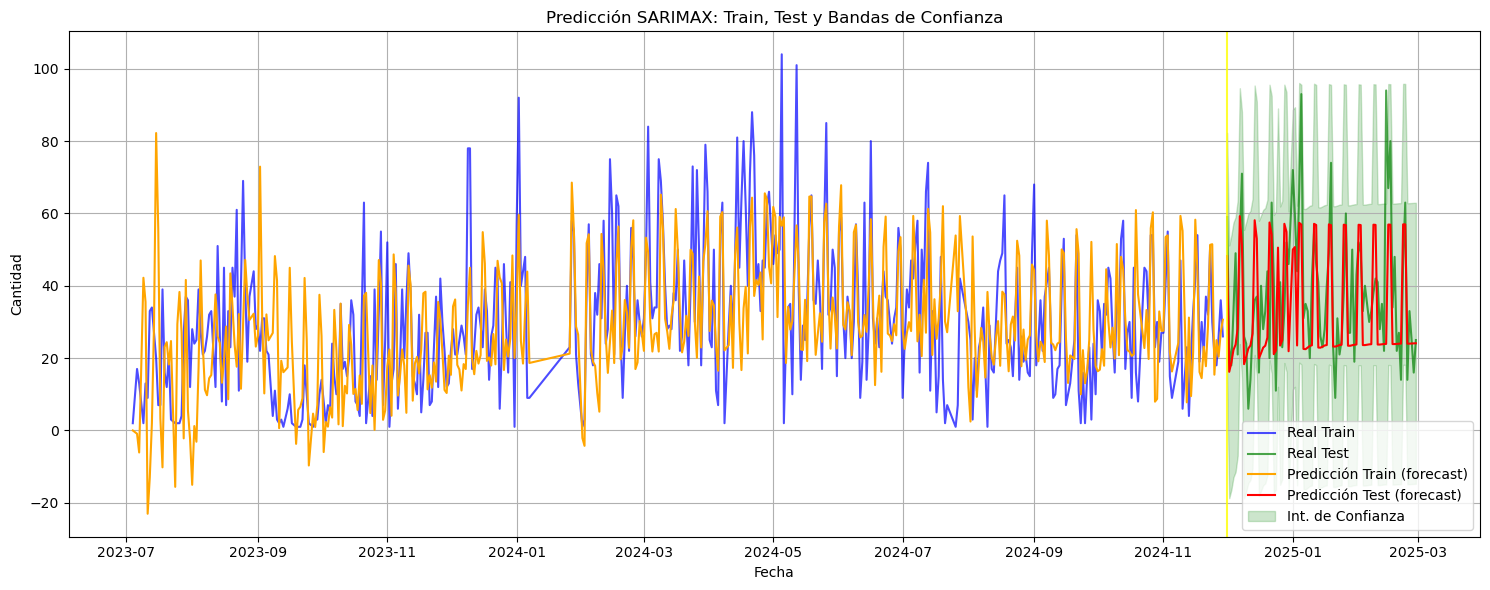

In [111]:
plt.figure(figsize=(15,6))

# Real en train y test
plt.plot(df_train.index, df_train['cantidad'], label='Real Train', color='blue', alpha=0.7)
plt.plot(df_test.index, df_test['cantidad'], label='Real Test', color='green', alpha=0.7)

# Predicción en train
plt.plot(df_train.index, fitted_train, label='Predicción Train (forecast)', color='orange')

# Predicción en test
plt.plot(df_test.index, forecast_mean, label='Predicción Test (forecast)', color='red')

# Bandas de confianza en test
plt.fill_between(df_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2, label='Int. de Confianza')

# línea vertical para marcar el corte train/test
plt.axvline(df_test.index[0], color='yellow', alpha=0.8)

plt.title('Predicción SARIMAX: Train, Test y Bandas de Confianza')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 6. Pronóstico de la demanda para producto **Batido de Helado**

In [112]:
# Exogenas del 2025
df_day['fecha'] = pd.to_datetime(df_day['fecha'])
df_current_year = df_day[(df_day['fecha'].dt.year == 2025) & (df_day['fecha'].dt.month > 2)]
df_current_year['es_fin_semana'] = np.where(df_current_year['tipo_dia'] == 'Fin de semana', 1, 0)
df_current_year['es_festivo'] = np.where(df_current_year['tipo_dia'] == 'Festivo', 1, 0)

df_exg = df_current_year[['es_festivo','es_fin_semana']]
future_dates = pd.date_range(start=df_test.index.max() + pd.Timedelta(days=1), end='2025-12-31', freq='D')

In [116]:
# Proóstico para todo 2025
forecast_2025 = fit_final.get_forecast(steps=len(future_dates), exog=df_exg)
forecast_mean_2025 = forecast_2025.predicted_mean
conf_int_2025 = forecast_2025.conf_int(alpha=0.05)
forecast_mean_2025.index = future_dates
conf_int_2025.index = future_dates

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



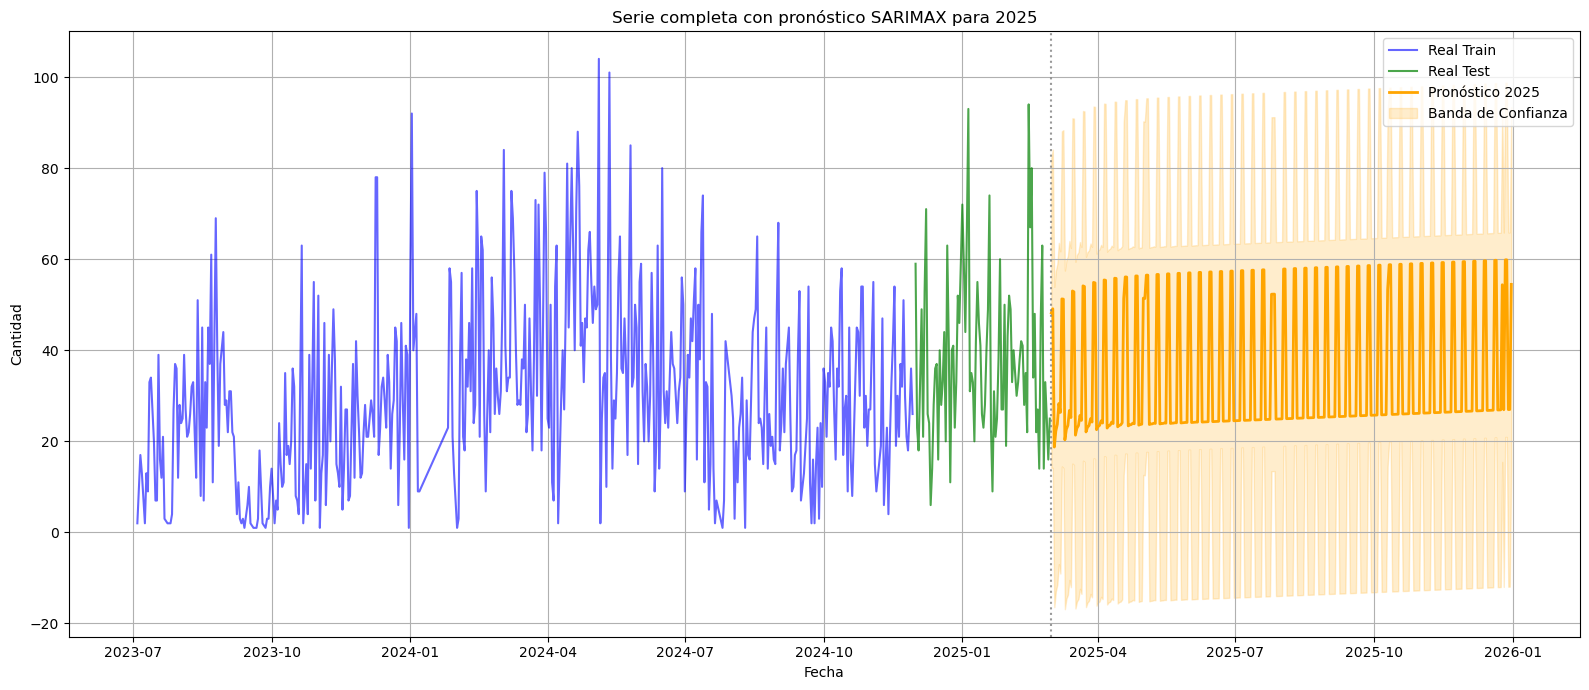

In [119]:
plt.figure(figsize=(16,7))

# Datos reales de train y test
plt.plot(df_train.index, df_train['cantidad'], label='Real Train', color='blue', alpha=0.6)
plt.plot(df_test.index, df_test['cantidad'], label='Real Test', color='green', alpha=0.7)

# Pronóstico para 2025
plt.plot(forecast_mean_2025.index, forecast_mean_2025, label='Pronóstico 2025', color='orange', linewidth=2)

# Bandas de confianza en pronóstico
plt.fill_between(
    forecast_mean_2025.index, 
    conf_int_2025.iloc[:, 0], 
    conf_int_2025.iloc[:, 1], 
    color='orange', alpha=0.2, label='Banda de Confianza'
)

# Línea para marcar el inicio del pronóstico
plt.axvline(forecast_mean_2025.index[0], color='grey', linestyle=':', alpha=0.8)

plt.title('Serie completa con pronóstico SARIMAX para 2025')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Resultado:
- La serie histórica presenta una alta variabilidad diaria, con valores que fluctúan de manera significativa, especialmente en los periodos centrales del histórico.
- El periodo de prueba (test) mantiene una dinámica similar a la del train, lo que sugiere que el modelo ha sido validado sobre una muestra representativa.
- El pronóstico para 2025 proyecta una tendencia relativamente estable, manteniéndose dentro de rangos esperados de la serie histórica.
- El modelo no muestra saltos abruptos ni cambios artificiales en el comportamiento previsto para 2025, lo que indica robustez en la proyección.
- El patrón estacional semanal se refleja en las oscilaciones de la curva naranja, replicando el comportamiento histórico.
- La banda de confianza se amplía progresivamente a medida que avanza el año 2025, reflejando el aumento natural de la incertidumbre conforme se predice más lejos en el tiempo.
- Esta amplitud es esperada en modelos SARIMAX y es una señal de modelo bien calibrado, que no subestima la incertidumbre futura.
- El modelo SARIMAX pronostica para 2025 una evolución coherente con el comportamiento histórico, sin desviaciones extrañas ni signos de sobreajuste.

**7. Almacenamiento de Dataset de histórico y pronósticos de la demanda de BATIDOS DE HELADO.**

In [166]:
df_forecast_2025 = pd.DataFrame(forecast_mean_2025)
df_forecast_2025 = df_forecast_2025.rename(columns={'predicted_mean':'cantidad'})


df_forecast_2025 = pd.merge(df_forecast_2025, df_current_year, left_index=True, right_on='fecha')
df_forecast_2025 = df_forecast_2025.set_index('fecha')
df_forecast_2025 = df_forecast_2025[['cantidad','es_fin_semana','es_festivo']]


In [167]:
df_forecast_2025

,cantidad,es_fin_semana,es_festivo
fecha,,,
2025-03-01,48.211805,1,0
2025-03-02,49.116644,1,0
2025-03-03,18.745116,0,0
2025-03-04,22.247086,0,0
2025-03-05,23.757772,0,0
...,...,...,...
2025-12-27,59.854596,1,0
2025-12-28,59.868778,1,0
2025-12-29,26.980829,0,0


In [169]:
df_historico = pd.concat([df_train, df_test,df_forecast_2025], sort=False)

df_historico = df_historico.rename(columns={'cantidad':'batido_helado'})
df_historico

,batido_helado,es_festivo,es_fin_semana
fecha,,,
2023-07-04,2.000000,0,0
2023-07-06,17.000000,0,0
2023-07-07,13.000000,0,0
2023-07-09,2.000000,0,1
2023-07-10,13.000000,0,0
...,...,...,...
2025-12-27,59.854596,0,1
2025-12-28,59.868778,0,1
2025-12-29,26.980829,0,0


In [ ]:
df_historico.to_csv('./data-sets/data_pronostico_producto_batido_helado.csv')